In [4]:

import astropy 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import ascii

#put all the component fits files into an array
component_array = ["1088284872", "1088284992", "1088285112", "1088285232", "1088285600",  "1088285720", "1088285848", "1088285968", "1088286088", "1088286208", "1088286336"]

for i in component_array:
    components = '/Users/georgiaalexakis/ToR - GitHub Repository/radio-eyes/wk2_imaging/components/' + i +'_components.fits'

    hdu_list = fits.open(components, memmap=True)


    info_array = hdu_list[1].data

    ra = info_array['RIGHTASCENSION']
    dec = info_array['DECLINATION']
    flux = info_array['FLUXI']
    #used eyed instead of id since id is already a taken name
    eyed = info_array['ID']
    
    # appropriate range for ra is [340,10] which goes over the 360 boundary, to mitigate this we add an offset such that the effective ra range is [-20, 10]!
    ra[ra > 180] -= 360


    # here i am setting up the initial data in the array by putting the data from the first fits file in the array.
    if component_array[0] == i:
        ra_overall = ra
        dec_overall = dec
        eyed_overall = eyed
        flux_overall = flux
    #for all else, it appends to the new variable to make a REALLY BIG ARRAY OF EVERYTHING EVER
    else:
        ra_overall = np.append(ra_overall, ra)
        dec_overall = np.append(dec_overall, dec)
        eyed_overall = np.append(eyed_overall, eyed)
        flux_overall = np.append(flux_overall, flux)

print(ra_overall[0])

-0.2121582


In [5]:
#testing to see if the ra_overall array is arraying properly
tests = '/Users/georgiaalexakis/ToR - GitHub Repository/radio-eyes/wk2_imaging/components/1088284872_components.fits'

test = fits.open(tests)
test_array = test[1].data
print(test_array['RIGHTASCENSION'])


[[359.78784 359.69266  11.56608 ... 341.59064 355.421   346.16144]]


In [6]:
def pixelate(ra_zoom, dec_zoom, n_bins, ra_overall, dec_overall, eyed_overall, flux_overall):

    #Check to see which dimension is larger so that a square in ra,dec can 
    #be returned
    if (ra_zoom[1] - ra_zoom[0]) > (dec_zoom[1] - dec_zoom[0]):
        zoom = ra_zoom
    else:
        zoom = dec_zoom

    #Find the size of the bins using the largest dimension and the num of bins
    binsize = (zoom[1] - zoom[0]) / n_bins

    #Create arrays for ra and dec that give the left side of each pixel
    ra_bin_array = np.multiply(range(n_bins), binsize) + ra_zoom[0]
    dec_bin_array = np.multiply(range(n_bins), binsize) + dec_zoom[0]

    #Create an empty array of pixels to be filled in the for loops
    pixels = np.zeros((len(ra_bin_array),len(dec_bin_array)))

    #Histogram components into ra bins
    ra_histogram = np.digitize(ra_overall,ra_bin_array)

    #Begin for loop over both dimensions of pixels, starting with ra
    for bin_i in range(len(ra_bin_array) - 2):

        #Find the indices that fall into the current ra bin slice
        ra_inds = np.where(ra_histogram == bin_i)

        #Go to next for cycle if no indices fall into current ra bin slice
        if len(ra_inds) == 0:
            continue

        #Histogram components that fall into the current ra bin slice by dec
        dec_histogram = np.digitize(dec_overall[ra_inds],dec_bin_array)

        #Begin for loop by dec over ra bin slice
        for bin_j in range(len(dec_bin_array) - 2):
            
            #Find the indicies that fall into the current dec bin
            dec_inds = np.where(dec_histogram == bin_j)

            #Go to next for cycle if no indices fall into current dec bin			
            if len(dec_inds) == 0:
                continue

            #Sum the flux components that fall into current ra/dec bin
            pixels[bin_i,bin_j] = np.sum(flux_overall[(ra_inds[0])[dec_inds[0]]])

    #Find the pixel centers in ra/dec for plotting purposes
    ra_pixel_centers = np.multiply(range(n_bins),binsize) + ra_zoom[0] + (binsize / 2)
    dec_pixel_centers = np.multiply(range(n_bins),binsize) + dec_zoom[0] + (binsize / 2)

    return pixels, ra_pixel_centers, dec_pixel_centers

/var/folders/lh/gjdx4kyj4m9f7bzk50cysp6r0000gn/T/ipykernel_76463/4251285404.py:36: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.transpose(np.log(pixels2)), interpolation = "nearest", origin = "lower", cmap = "plasma",


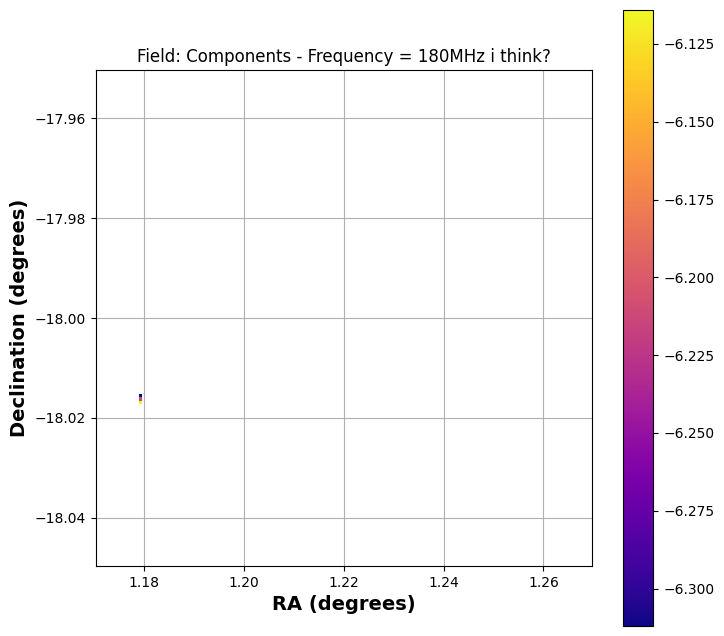

In [34]:
# ra and dec range values tend to be in range: ra = [340, 10], dec = [-40,-10], but the ra range goes over the 360 boundary so we can do: ra[ra>180] -= 360 such that 
# the ra range is now [-20,10]
ra_zoom = [1.17,1.18] 
dec_zoom = [-18.05,-17.95] 
# [0,2], [-20,-16]

#bin number affects how pixelated the image is, the smaller the bin number the lower the resolution of the image is (cause pixels are huge)
n_bins = 150

#remove unecessary elements in array so it doesnt plot everything!
range_of_ra_dec = np.where((ra_overall >= ra_zoom[0]) & (ra_overall <= ra_zoom[1]) & (dec_overall >= dec_zoom[0]) & (dec_overall <= dec_zoom[1]))
#print(range_of_ra_dec)
new_ra = ra_overall[range_of_ra_dec]
new_dec = dec_overall[range_of_ra_dec]
new_flux = flux_overall[range_of_ra_dec]
new_eyed = eyed_overall[range_of_ra_dec]


#pixels, ra_pixel_centres, dec_pixel_centers are the info returned from the pixelate function
(pixels, ra_pixel_centers, dec_pixel_centers) = pixelate(ra_zoom, dec_zoom, n_bins, new_ra, new_dec, new_eyed, new_flux)

#represents the total number of observations
n_obs = len(component_array)

#finds the average flux by dividing by the total number of observations
pixels2 = pixels / n_obs

#figsize scales the plot, in this case i chose 10,10 square so its relatively big and easy to see!
plt.figure(figsize=(8,8))

#imshow is a type of plot that shows the image (duh)
#took the log of the flux scale which made things happen
#interpolation made the pixels not fuzzy
#origin reoriented the y axis so it goes from 0 to 100 instead of 100 to 0
#cmap changed the colorbar so that the colors are sequentially dark-light in relation to flux
plt.imshow(np.transpose(np.log(pixels2)), interpolation = "nearest", origin = "lower", cmap = "plasma", 
           extent = [ra_pixel_centers[0], ra_pixel_centers[len(ra_pixel_centers)-1], 
           dec_pixel_centers[0], dec_pixel_centers[len(dec_pixel_centers)-1]])

#the x and y axis labels are not accurate right now but that's okay :)
plt.xlabel('RA (degrees)', fontweight='bold', size=14)
plt.ylabel('Declination (degrees)', fontweight='bold', size=14)
plt.title('Field: Components - Frequency = 180MHz i think?')

plt.colorbar()
plt.grid()
plt.show()